In [469]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [429]:
quant = [50, 95]
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa'
exp_name = ['pre_industrial', 'co2_2x']
n_exp = len(exp_name)
exp_path = [f'{data_dir}/{exp_name[i]}/output.nd2' for i in range(n_exp)]
exp_labels = ['Pre industrial', '$CO_2 \\times 2$']
ds = []
var_keep = ['TREFHT', 'QREFHT', 'PS', 'T', 'T_zonal_av', 'T_anom', 'Z3']       # only need these, as compute everything else from average profile
# compute_offline = False             # If True, compute LCL etc from average profile, otherwise load in info averaged over values on each day
# if not compute_offline:
#     var_keep += ['T', 'T_zonal_av', 'T_anom', 'p_at_lcl', 'T_at_lcl', 'lapse_below_lcl', 'lapse_above_lcl']
for i in tqdm(range(n_exp)):
    ds.append(xr.open_dataset(exp_path[i]).isel(plev=0).sel(quant=quant)[var_keep].load())

  0%|          | 0/2 [00:00<?, ?it/s]

In [430]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds[0]['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0), ds.hybm.isel(time=0), float(ds.P0.isel(time=0))
hyam, hybm, p0 = get_lev_info()

### Compute LCL and bulk lapse rates from average temperature profile
Below I compute the LCL, the environmental temperature at the LCL, and the bulk lapse rates above and below the LCL from the average temperature profile at each location.

In [431]:
# Compute LCL and lapse rate stuff offline from average temperature profile
exp_path_prof='/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/av_profile/above_TREFHTquant'
def get_temp_profile_info(exp_ind, p_surface, p_lcl, exp_path_prof=exp_path_prof, ds_prof=None):
    # returns T_at_lcl, p_at_lcl, T
    if ds_prof is None:
        ds_prof = xr.load_dataset(f"{exp_path_prof}/T/{exp_name[exp_ind]}/output.nd2").sel(quant=quant)[['T']]
    ds_interp = interp_var_at_pressure(ds_prof, p_lcl, p_surface, hyam, hybm, p0)
    return ds_interp.T, ds_interp.plev

In [432]:
surf_model_level = -3
for i in tqdm(range(n_exp)):
    if surf_model_level is None:
        # Use actual REFHT
        ds[i]['PREFHT'] = ds[i].PS
        ds[i]['ZREFHT'] = z2m
        ds[i]['p_lcl'], ds[i]['T_lcl'] = lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PREFHT)
        ds[i]['Z3_lcl'] = ds[i].ZREFHT + (ds[i].TREFHT - ds[i]['T_lcl']) / lapse_dry
        ds[i]['T_at_lcl'], ds[i]['p_at_lcl'] = get_temp_profile_info(i, ds[i].PS, ds[i].p_lcl)
    else:
        # Use model level as REFHT
        ds_prof = xr.merge([xr.open_dataset(f"{exp_path_prof}/T/{exp_name[i]}/output.nd2").sel(quant=quant)[['T']],
                    xr.open_dataset(f"{exp_path_prof}/Z/{exp_name[i]}/output.nd2").sel(quant=quant)[['Z3']],
                    xr.open_dataset(f"{exp_path_prof}/Q/{exp_name[i]}/output.nd2").sel(quant=quant)[['Q']]])
        ds[i]['PREFHT'] = isca_tools.cesm.get_pressure(ds[i].PS, p0, hyam.isel(lev=surf_model_level), hybm.isel(lev=surf_model_level))
        ds[i]['TREFHT'] = ds_prof.T.isel(lev=surf_model_level)
        ds[i]['QREFHT'] = ds_prof.Q.isel(lev=surf_model_level)
        ds[i]['ZREFHT'] = ds_prof.Z3.isel(lev=surf_model_level)

        ds[i]['p_lcl'], ds[i]['T_lcl'] = lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PREFHT)
        ds[i]['Z3_lcl'] = ds[i].ZREFHT + (ds[i].TREFHT - ds[i]['T_lcl']) / lapse_dry

        ds[i]['T_at_lcl'], ds[i]['p_at_lcl'] = get_temp_profile_info(i, ds[i].PS, ds[i].p_lcl, ds_prof=ds_prof[['T']])
    ds[i]['lapse_below_lcl'] = get_bulk_lapse_rate(ds[i].TREFHT, ds[i].T_at_lcl, ds[i].PREFHT, ds[i].p_at_lcl) * 1000
    ds[i]['lapse_above_lcl'] = get_bulk_lapse_rate(ds[i].T_at_lcl, ds[i].T, ds[i].p_at_lcl, float(ds[i].plev)) * 1000
    ds[i] = ds[i].load()
# Have both co2 levels in same dataset
ds = xr.concat(ds, dim=xr.DataArray([get_co2_multiplier(exp_name[i]) for i in range(n_exp)], name='co2', dims='co2'))

  0%|          | 0/2 [00:00<?, ?it/s]

## Reconstructing $T_{2m}$
First I do a sanity check that with the actual pressure, the equation reconstructs the exact $T_{2m}$.

In [8]:
show_plot = False
var = reconstruct_temp(ds.T, ds.PREFHT, ds.p_at_lcl, 500*100, ds.lapse_below_lcl/1000, ds.lapse_above_lcl/1000)
if show_plot:
    np.abs(var-ds.TREFHT).plot(vmin=0, vmax=2)
    plt.show()
print(f"{float(np.abs(var-ds.TREFHT).quantile(0.99)):.3g}")

2.16e-12


In [341]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

## Temperature Anomaly
Here, I breakdown what causes the hottest 5% of days to be warmer than the average over the hottest 50% of days.
### Compare theory to simulated
First, I confirm that the linear decomposition is pretty accurate.

In [10]:
TREFHT_anom_breakdown_anom = {'T500': ds.T.isel(quant=1) - ds.T.isel(quant=0),
                              'lapse_below_lcl': ds.lapse_below_lcl.isel(quant=1) - ds.lapse_below_lcl.isel(quant=0),
                              'lapse_above_lcl': ds.lapse_above_lcl.isel(quant=1) - ds.lapse_above_lcl.isel(quant=0),
                              'p_lcl': (ds.p_lcl/ds.PREFHT).isel(quant=1) - (ds.p_lcl/ds.PREFHT).isel(quant=0),
                              'p_s': (ds.plev/ds.PREFHT).isel(quant=1) - (ds.plev/ds.PREFHT).isel(quant=0)}
TREFHT_anom_breakdown_sensitivity = {'T500': (ds.TREFHT/ds.T).isel(quant=0),
                                     'lapse_below_lcl': -(ds.TREFHT * np.log(ds.p_lcl/ds.PREFHT)).isel(quant=0) * R/g / 1000,
                                     'lapse_above_lcl': (ds.TREFHT * np.log(ds.p_lcl/ds.plev)).isel(quant=0) * R/g / 1000,
                                     'p_lcl': R/g * ((ds.lapse_above_lcl-ds.lapse_below_lcl)/1000 * ds.PREFHT/ds.p_lcl * ds.TREFHT).isel(quant=0),
                                     'p_s': -R/g * (ds.lapse_above_lcl/1000 * ds.PREFHT/ds.plev * ds.TREFHT).isel(quant=0)}
TREFHT_anom_breakdown_cont = {key: TREFHT_anom_breakdown_anom[key] * TREFHT_anom_breakdown_sensitivity[key]
                              for key in TREFHT_anom_breakdown_anom}
TREFHT_anom_theory = sum(TREFHT_anom_breakdown_cont.values())
TREFHT_anom = ds.TREFHT.isel(quant=1)-ds.TREFHT.isel(quant=0)

# Add T_ft breakdown
TREFHT_anom_breakdown_anom['T500_zonal_av'] = ds.T_zonal_av.isel(quant=1) - ds.T_zonal_av.isel(quant=0)
TREFHT_anom_breakdown_anom['T500_anom'] = ds.T_anom.isel(quant=1) - ds.T_anom.isel(quant=0)
for key in ['T500_zonal_av', 'T500_anom']:
    TREFHT_anom_breakdown_sensitivity[key] = TREFHT_anom_breakdown_sensitivity['T500']
    TREFHT_anom_breakdown_cont[key] = TREFHT_anom_breakdown_anom[key] * TREFHT_anom_breakdown_sensitivity[key]

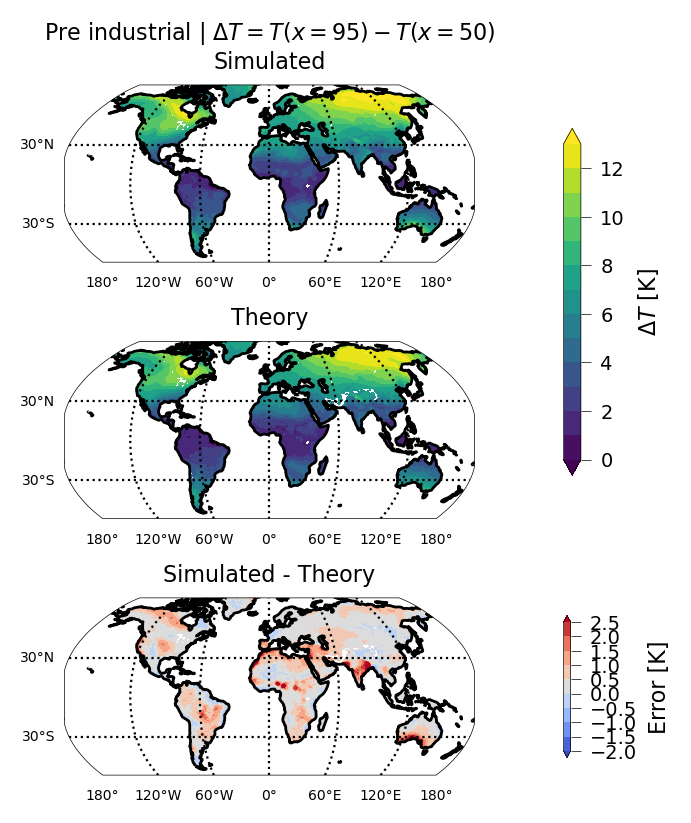

In [350]:
lat_plot_min = -60
lat_plot_max = 80
# norm_by_av = 'FT'
co2_ind = 0
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(3,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0, 14, 1)
plot_contour_projection(ax[0], TREFHT_anom.isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1], TREFHT_anom_theory.isel(co2=co2_ind), cmap='viridis', levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2], TREFHT_anom.isel(co2=co2_ind) - TREFHT_anom_theory.isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-2, 3, 0.5))
# im = plot_contour_projection(ax[1], var_theory,
#                              levels=levels_temp_change[norm_by_av],
#                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'{exp_labels[0]} | $\Delta T = T(x={ds.quant[1]:.0f}) - T(x={ds.quant[0]:.0f})$\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
isca_tools.savefig(fig)
plt.show()

### Breakdown of mechanisms
Below, I plot the contribution from each mechanism to the anomaly in a given climate.

In [12]:
units_breakdown = {'change': {'p_lcl': 'Pa/Pa', 'p_s': 'Pa/Pa', 'T500': 'K', 'lapse_below_lcl': 'K/km', 'lapse_above_lcl': 'K/km'},
                   'sensitivity': {'p_lcl': 'K', 'p_s': 'K', 'T500': 'K/K', 'lapse_below_lcl': 'km', 'lapse_above_lcl': 'km'}}
name_breakdown = {'T500_zonal_av': '$\overline{T_{500}}$', 'T500_anom': '$\Delta T_{500}$', 'p_lcl': '$\sigma_{LCL}$',
                  'p_s': '$\sigma_{500}$', 'lapse_below_lcl': '$\Gamma_{<LCL}$', 'lapse_above_lcl': '$\Gamma_{>LCL}$'}

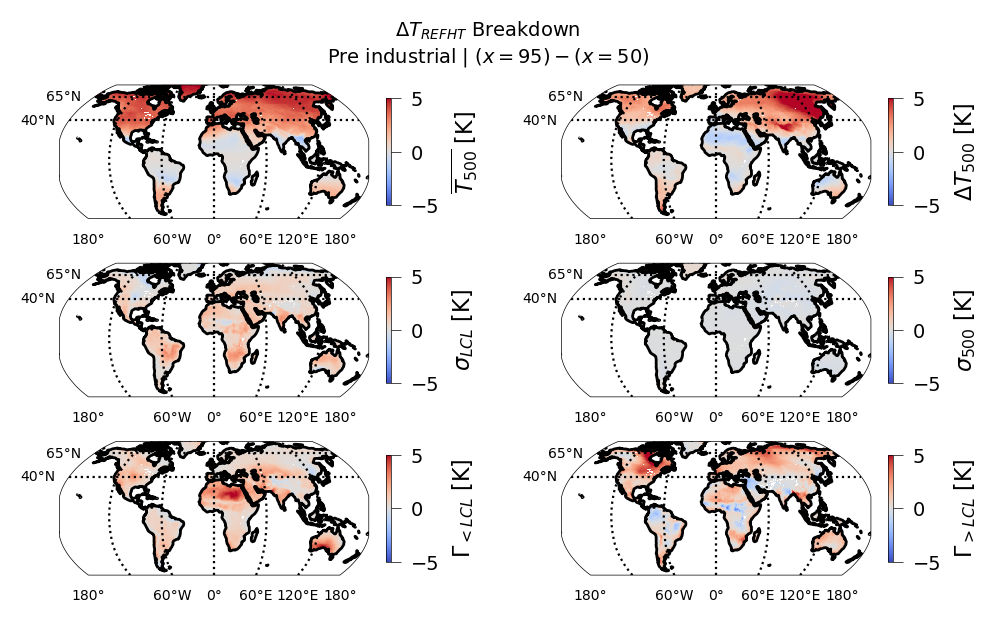

In [107]:
co2_ind=0
fig = plt.figure(constrained_layout=True,figsize=(10/2,len(name_breakdown)/2))
ax = fig.subplots(3,2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax = ax.flatten()
for i, key in enumerate(name_breakdown):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values, TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind).where(land>0),
                        transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-5, vmax=5)
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
    fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.suptitle(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')
plt.show()

### Most important mechanism
Below, I plot which mechanism is most important in setting the anomaly in a given climate.

In [61]:
TREFHT_anom_cont_abs_sum = sum([np.abs(TREFHT_anom_breakdown_cont[key]) for key in name_breakdown])
TREFHT_anom_cont_frac = [(np.abs(TREFHT_anom_breakdown_cont[key]).where(land>0) / TREFHT_anom_cont_abs_sum).isel(co2=co2_ind) for key in name_breakdown]
TREFHT_anom_cont_frac = xr.concat(TREFHT_anom_cont_frac, dim=xr.DataArray(list(name_breakdown.keys()), name='mechanism', dims='mechanism'))

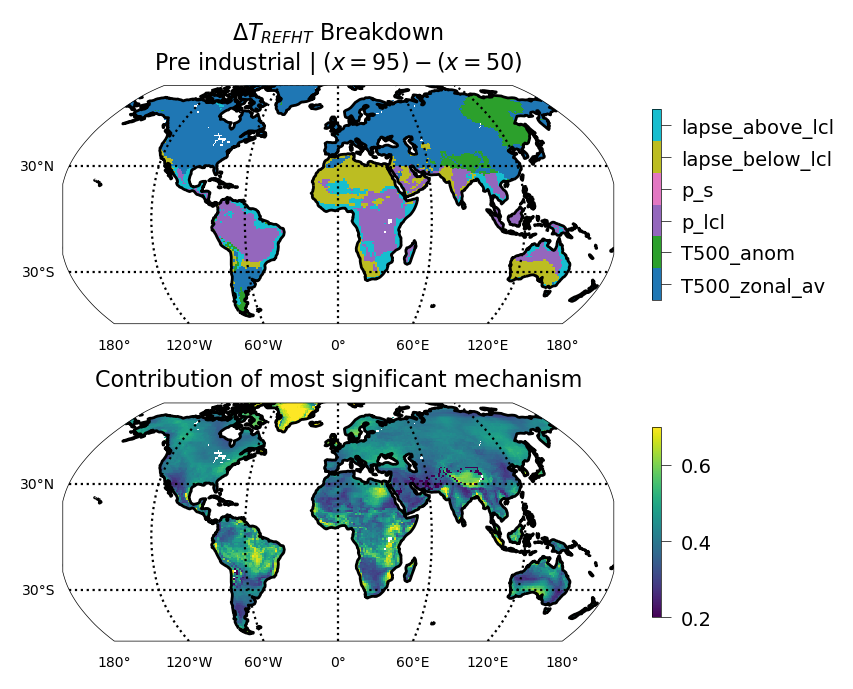

In [342]:
co2_ind = 0
mask_use = land>0
# mask_use = TREFHT_anom_cont_frac.max(dim='mechanism')>0.35
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 5, ar=3)
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)


cmap = plt.get_cmap('tab10', len(name_breakdown))  # discrete colormap with 6 colors
norm = mcolors.BoundaryNorm(np.arange(len(name_breakdown)+1)-0.5, len(name_breakdown))
im = TREFHT_anom_cont_frac.fillna(0).argmax(dim='mechanism').where(mask_use).plot(ax=ax[0], cmap=cmap, norm=norm, add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())
# Custom colorbar with labels
cbar = fig.colorbar(im, ax=ax[0], ticks=np.arange(len(name_breakdown)), shrink=0.8)
cbar.ax.set_yticklabels(name_breakdown)
ax[0].set_title(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')

im = TREFHT_anom_cont_frac.max(dim='mechanism').where(mask_use).plot(ax=ax[1], cmap='viridis', add_colorbar=False,
                                                                     transform=ccrs.PlateCarree(), vmin=0.2, vmax=0.7)
fig.colorbar(im, ax=ax[1], shrink=0.8)
ax[1].set_title('Contribution of most significant mechanism')
# isca_tools.savefig(fig)
plt.show()

## Change in anomaly with warming
Here I look at the mechanisms causing the anomaly shown above to change with warming i.e. why does the shape of the distribution change with warming.

### Compare theory to simulated
As before, we check that the simulated change is well explained by the linear theory.

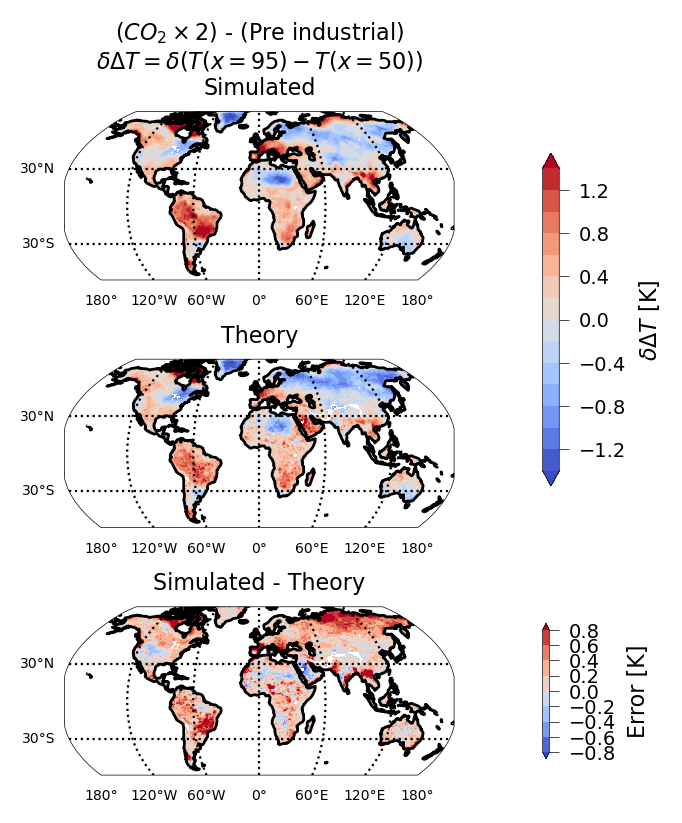

In [351]:
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(3,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0, 14, 1)
plot_contour_projection(ax[0], TREFHT_anom.isel(co2=1) - TREFHT_anom.isel(co2=0),
                        cmap='coolwarm', levels=np.arange(-1.4, 1.6, 0.2))
im = plot_contour_projection(ax[1], TREFHT_anom_theory.isel(co2=1) - TREFHT_anom_theory.isel(co2=0), cmap='coolwarm', levels=np.arange(-1.4, 1.6, 0.2))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\delta \Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2], TREFHT_anom.isel(co2=1) - TREFHT_anom.isel(co2=0) -
                             (TREFHT_anom_theory.isel(co2=1) - TREFHT_anom_theory.isel(co2=0)),
                             cmap='coolwarm', levels=np.arange(-0.8, 1, 0.2))
# im = plot_contour_projection(ax[1], var_theory,
#                              levels=levels_temp_change[norm_by_av],
#                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'({exp_labels[1]}) - ({exp_labels[0]})\n$\delta \Delta T = \delta (T(x={ds.quant[1]:.0f}) - T(x={ds.quant[0]:.0f}))$\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

### Breakdown of mechanisms
Below, I plot the contribution from each mechanism to the change in anomaly with warming.

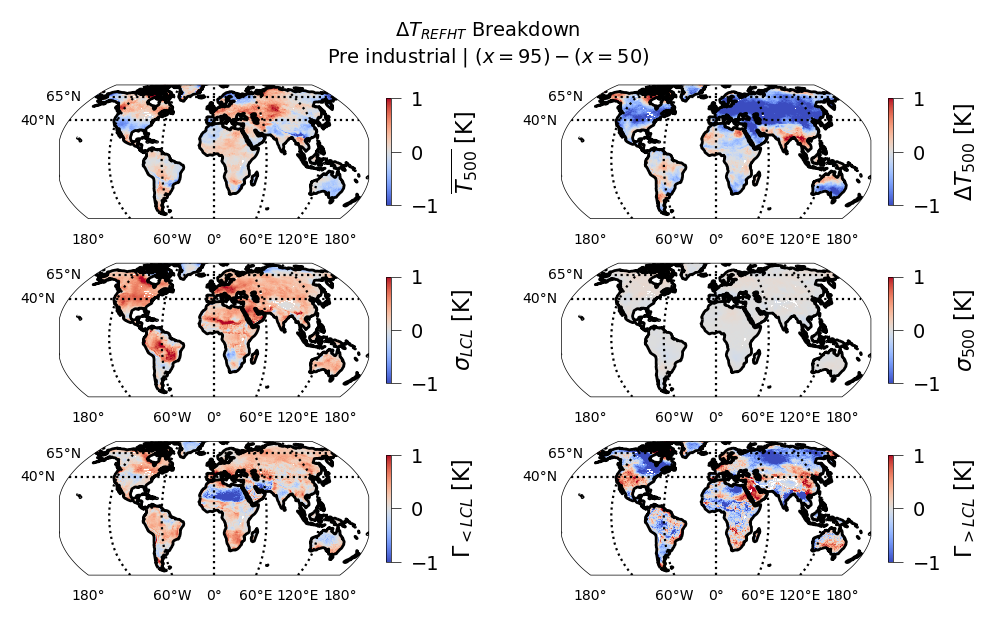

In [120]:
fig = plt.figure(constrained_layout=True,figsize=(10/2,len(name_breakdown)/2))
ax = fig.subplots(3,2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax = ax.flatten()
for i, key in enumerate(name_breakdown):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values,
                          (TREFHT_anom_breakdown_cont[key].isel(co2=1) - TREFHT_anom_breakdown_cont[key].isel(co2=0)).where(land>0),
                          transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-1, vmax=1)
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
    fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.suptitle(f'$\delta \Delta T_{"{REFHT}"}$ Breakdown\n({exp_labels[1]}) - ({exp_labels[0]}) | $(x={quant[1]}) - (x={quant[0]})$')
plt.show()

### Most important mechanism
Below, I plot which mechanism is most important in changing the anomaly with warming.

In [124]:
TREFHT_anom_change_cont_abs_sum = sum([np.abs(TREFHT_anom_breakdown_cont[key].isel(co2=1) - TREFHT_anom_breakdown_cont[key].isel(co2=0))
                                       for key in name_breakdown])
TREFHT_anom_change_cont_frac = [(np.abs(TREFHT_anom_breakdown_cont[key].isel(co2=1) -
                                        TREFHT_anom_breakdown_cont[key].isel(co2=0)).where(land>0) / TREFHT_anom_change_cont_abs_sum)
                                for key in name_breakdown]
TREFHT_anom_change_cont_frac = xr.concat(TREFHT_anom_change_cont_frac, dim=xr.DataArray(list(name_breakdown.keys()), name='mechanism', dims='mechanism'))

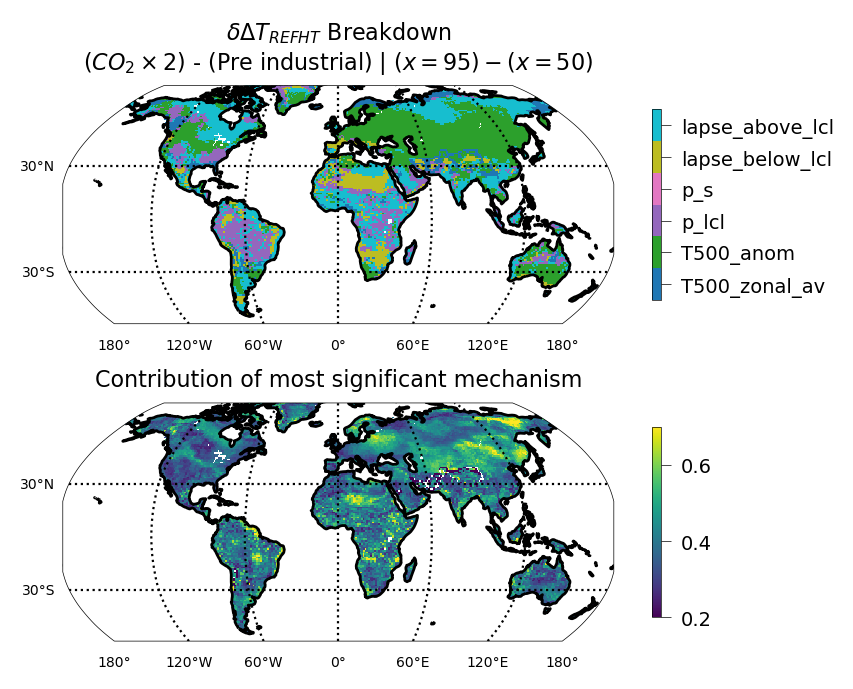

In [343]:
mask_use = land>0
# mask_use = TREFHT_anom_change_cont_frac.max(dim='mechanism')>0.35
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 5, ar=3)
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)


cmap = plt.get_cmap('tab10', len(name_breakdown))  # discrete colormap with 6 colors
norm = mcolors.BoundaryNorm(np.arange(len(name_breakdown)+1)-0.5, len(name_breakdown))
im = TREFHT_anom_change_cont_frac.fillna(0).argmax(dim='mechanism').where(mask_use).plot(ax=ax[0], cmap=cmap, norm=norm, add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())
# Custom colorbar with labels
cbar = fig.colorbar(im, ax=ax[0], ticks=np.arange(len(name_breakdown)), shrink=0.8)
cbar.ax.set_yticklabels(name_breakdown)
ax[0].set_title(f'$\delta \Delta T_{"{REFHT}"}$ Breakdown\n({exp_labels[1]}) - ({exp_labels[0]}) | $(x={quant[1]}) - (x={quant[0]})$')

im = TREFHT_anom_change_cont_frac.max(dim='mechanism').where(mask_use).plot(ax=ax[1], cmap='viridis', add_colorbar=False,
                                                                     transform=ccrs.PlateCarree(), vmin=0.2, vmax=0.7)
fig.colorbar(im, ax=ax[1], shrink=0.8)
ax[1].set_title('Contribution of most significant mechanism')
# isca_tools.savefig(fig)
plt.show()

## Change of given percentile relative to spatial average
This considers the change with warming above a given percentile, and explains why there is a spatial variation in this. As the spatial average, I take the rolling average in window of 10$\degree$ in latitude.
### Compare theory to simulated
As before, we check that the simulated change is well explained by the linear theory.

In [217]:
quant_ind = 1
TREFHT_change_breakdown_change = {'T500': ds.T.isel(quant=quant_ind, co2=1) - ds.T.isel(quant=quant_ind, co2=0),
                              'lapse_below_lcl': ds.lapse_below_lcl.isel(quant=quant_ind, co2=1) - ds.lapse_below_lcl.isel(quant=quant_ind, co2=0),
                              'lapse_above_lcl': ds.lapse_above_lcl.isel(quant=quant_ind, co2=1) - ds.lapse_above_lcl.isel(quant=quant_ind, co2=0),
                              'p_lcl': (ds.p_lcl/ds.PREFHT).isel(quant=quant_ind, co2=1) - (ds.p_lcl/ds.PREFHT).isel(quant=quant_ind, co2=0),
                              'p_s': (ds.plev/ds.PREFHT).isel(quant=quant_ind, co2=1) - (ds.plev/ds.PREFHT).isel(quant=quant_ind, co2=0)}
TREFHT_change_breakdown_sensitivity = {'T500': (ds.TREFHT/ds.T).isel(quant=quant_ind, co2=0),
                                     'lapse_below_lcl': -(ds.TREFHT * np.log(ds.p_lcl/ds.PREFHT)).isel(quant=quant_ind, co2=0) * R/g / 1000,
                                     'lapse_above_lcl': (ds.TREFHT * np.log(ds.p_lcl/ds.plev)).isel(quant=quant_ind, co2=0) * R/g / 1000,
                                     'p_lcl': R/g * ((ds.lapse_above_lcl-ds.lapse_below_lcl)/1000 *
                                                     ds.PREFHT/ds.p_lcl * ds.TREFHT).isel(quant=quant_ind, co2=0),
                                     'p_s': -R/g * (ds.lapse_above_lcl/1000 * ds.PREFHT/ds.plev * ds.TREFHT).isel(quant=quant_ind, co2=0)}
TREFHT_change_breakdown_cont = {key: TREFHT_change_breakdown_change[key] * TREFHT_change_breakdown_sensitivity[key]
                              for key in TREFHT_change_breakdown_change}
TREFHT_change_theory = sum(TREFHT_change_breakdown_cont.values())
TREFHT_change = ds.TREFHT.isel(quant=quant_ind, co2=1)-ds.TREFHT.isel(quant=quant_ind, co2=0)

# Add T_ft breakdown
TREFHT_change_breakdown_change['T500_zonal_av'] = ds.T_zonal_av.isel(quant=quant_ind, co2=1) - ds.T_zonal_av.isel(quant=0, co2=0)
TREFHT_change_breakdown_change['T500_anom'] = ds.T_anom.isel(quant=quant_ind, co2=1) - ds.T_anom.isel(quant=quant_ind, co2=0)
for key in ['T500_zonal_av', 'T500_anom']:
    TREFHT_change_breakdown_sensitivity[key] = TREFHT_change_breakdown_sensitivity['T500']
    TREFHT_change_breakdown_cont[key] = TREFHT_change_breakdown_change[key] * TREFHT_change_breakdown_sensitivity[key]

In [345]:
lat_tropics = 30
mask_av_window = (land>0).where(land.lat > lat_plot_min).where(land.lat < lat_plot_max)
mask_av_window = mask_av_window>0
def get_var_anom(var, n_lat_av=30, mask=mask_av_window):
    # rolling average over n_lat_av latitude coordinates
    var_mean = var.where(mask).median(dim='lon').rolling(lat=n_lat_av, center=True).median()
    return var - var_mean
    # lat_tropics = 30
    # mean_tropics = var.where(np.abs(var.lat)<=lat_trop).where(mask).median(dim=['lat', 'lon'])
    # mean_elsewhere = var.where(np.abs(var.lat)>lat_trop).where(mask).median(dim=['lat', 'lon'])
    # return var - (var*0+mean_tropics).isel(lon=0).where(np.abs(var.lat)<=lat_trop, mean_elsewhere)

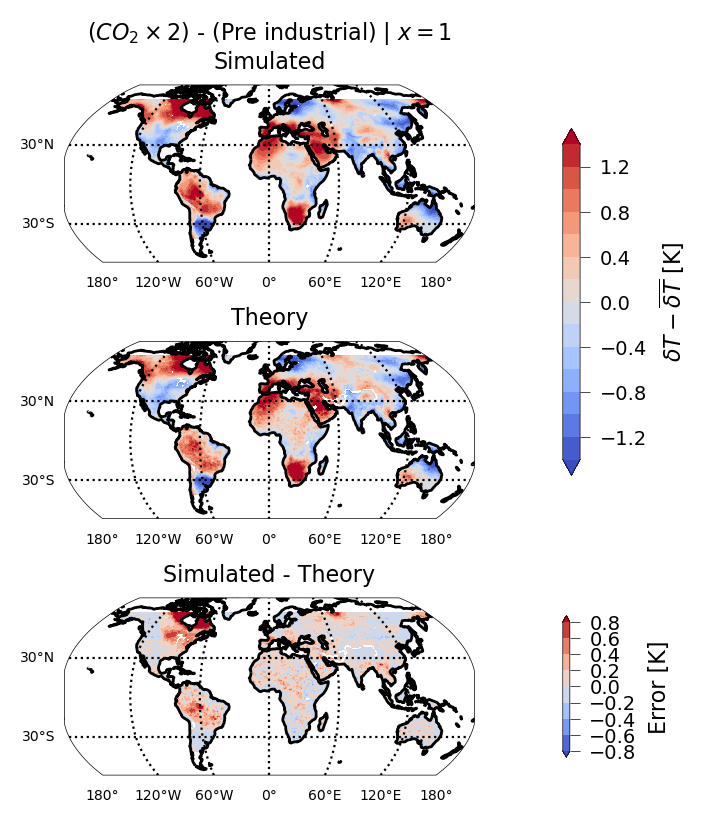

In [352]:
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(3,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])

levels_use = np.arange(0, 14, 1)
plot_contour_projection(ax[0], get_var_anom(TREFHT_change),
                        cmap='coolwarm', levels=np.arange(-1.4, 1.6, 0.2))
im = plot_contour_projection(ax[1], get_var_anom(TREFHT_change_theory), cmap='coolwarm', levels=np.arange(-1.4, 1.6, 0.2))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\delta T - \overline{\delta T}$ [K]', mappable=im)
im = plot_contour_projection(ax[2], get_var_anom(TREFHT_change) - get_var_anom(TREFHT_change_theory),
                             cmap='coolwarm', levels=np.arange(-0.8, 1, 0.2))
# im = plot_contour_projection(ax[1], var_theory,
#                              levels=levels_temp_change[norm_by_av],
#                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'({exp_labels[1]}) - ({exp_labels[0]}) | $x={quant[quant_ind]}$\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

### Breakdown of mechanisms
Below, I plot the contribution from each mechanism to the change with warming.

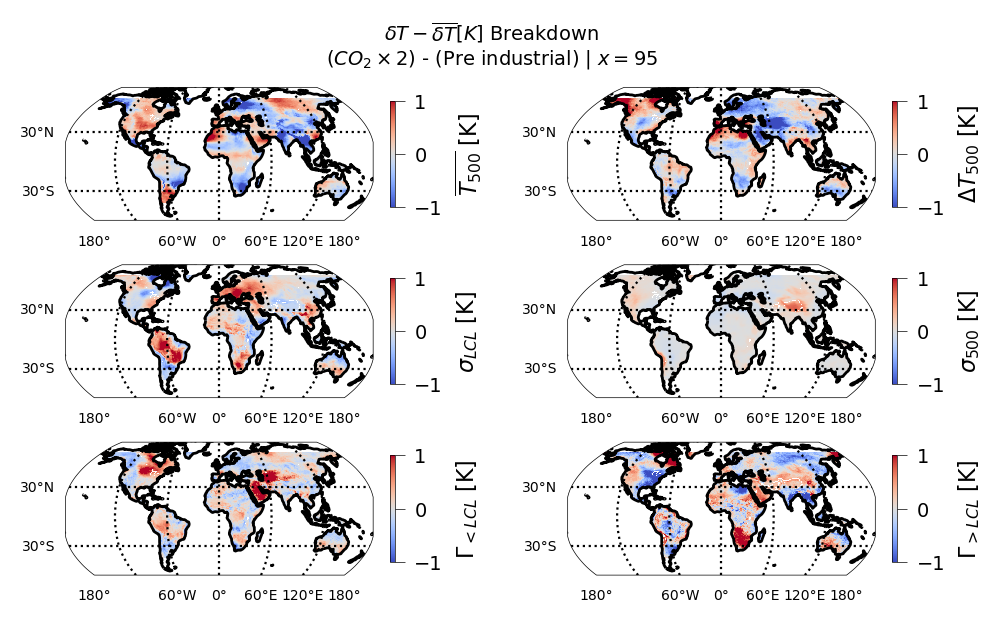

In [347]:
fig = plt.figure(constrained_layout=True,figsize=(10/2,len(name_breakdown)/2))
ax = fig.subplots(3,2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax = ax.flatten()
for i, key in enumerate(name_breakdown):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values, get_var_anom(TREFHT_change_breakdown_cont[key]).where(land>0),
                          transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-1, vmax=1)
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
    fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.suptitle('$\delta T - \overline{\delta T} [K]$ Breakdown\n'+f'({exp_labels[1]}) - ({exp_labels[0]}) | $x={quant[quant_ind]}$')
# isca_tools.savefig(fig)
plt.show()

### Most important mechanism
Below, I plot which mechanism is most important in changing the anomaly with warming.

In [348]:
TREFHT_change_cont_abs_sum = sum([np.abs(get_var_anom(TREFHT_change_breakdown_cont[key]))
                                       for key in name_breakdown])
TREFHT_change_cont_frac = [(np.abs(get_var_anom(TREFHT_change_breakdown_cont[key])).where(land>0) / TREFHT_change_cont_abs_sum)
                           for key in name_breakdown]
TREFHT_change_cont_frac = xr.concat(TREFHT_change_cont_frac, dim=xr.DataArray(list(name_breakdown.keys()), name='mechanism', dims='mechanism'))

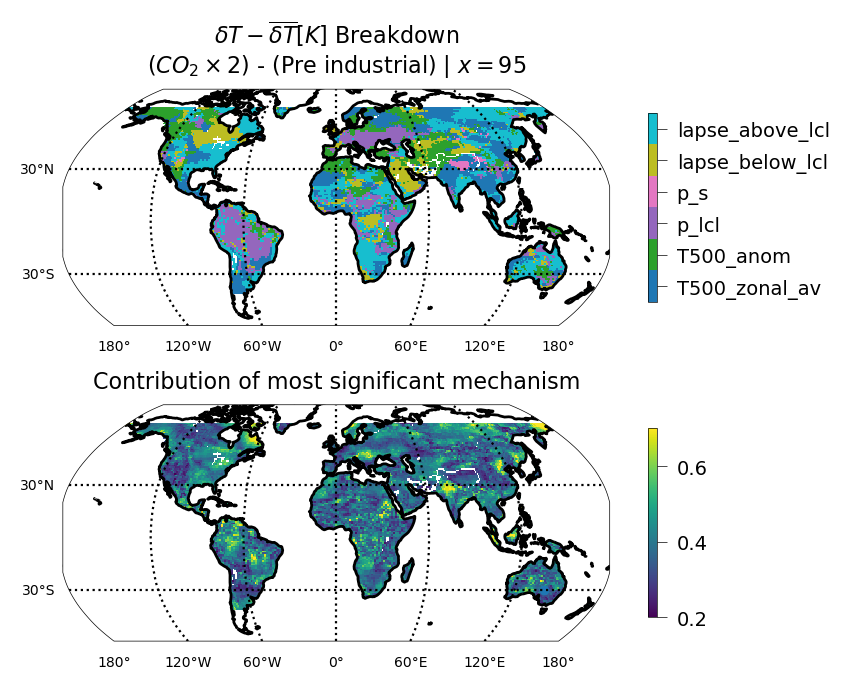

In [356]:
mask_use = land>0
mask_use = TREFHT_change_cont_frac.max(dim='mechanism').where(mask_use) > 0         # so avoid polar regions where can't average over 30 lat points
# mask_use = TREFHT_anom_change_cont_frac.max(dim='mechanism')>0.35
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 5, ar=3)
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])


cmap = plt.get_cmap('tab10', len(name_breakdown))  # discrete colormap with 6 colors
norm = mcolors.BoundaryNorm(np.arange(len(name_breakdown)+1)-0.5, len(name_breakdown))
im = TREFHT_change_cont_frac.fillna(0).argmax(dim='mechanism').where(mask_use).plot(ax=ax[0], cmap=cmap, norm=norm, add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())
# Custom colorbar with labels
cbar = fig.colorbar(im, ax=ax[0], ticks=np.arange(len(name_breakdown)), shrink=0.8)
cbar.ax.set_yticklabels(name_breakdown)
ax[0].set_title('$\delta T - \overline{\delta T} [K]$ Breakdown\n'+f'({exp_labels[1]}) - ({exp_labels[0]}) | $x={quant[quant_ind]}$')

im = TREFHT_change_cont_frac.max(dim='mechanism').where(mask_use).plot(ax=ax[1], cmap='viridis', add_colorbar=False,
                                                                     transform=ccrs.PlateCarree(), vmin=0.2, vmax=0.7)
fig.colorbar(im, ax=ax[1], shrink=0.8)
ax[1].set_title('Contribution of most significant mechanism')
ax[1].scatter(140, -30, transform=ccrs.PlateCarree())
plt.show()
# isca_tools.savefig(fig)

### Example profiles
Playing around with example temperature profiles

In [433]:
ds_prof = [xr.merge([xr.open_dataset(f"{exp_path_prof}/T/{exp_name[i]}/output.nd2").sel(quant=quant)[['T']],
                    xr.open_dataset(f"{exp_path_prof}/Z/{exp_name[i]}/output.nd2").sel(quant=quant)[['Z3']]]) for i in range(n_exp)]
ds_prof = xr.concat(ds_prof, dim=xr.DataArray([get_co2_multiplier(exp_name[i]) for i in range(n_exp)], name='co2', dims='co2'))

In [539]:
lat_plot_use = 50
lon_plot_use = 30
ds_use = ds_prof.sel(lat=lat_plot_use, lon=lon_plot_use, method='nearest').isel(lev=slice(0, surf_model_level+1))
for key in ['Z3', 'T', 'T_zonal_av', 'Z3_lcl']:
    ds_use[key+('' if 'lcl' in key else '_ft')] = ds.sel(lat=lat_plot_use, lon=lon_plot_use, method='nearest')[key]

(0.0, 25000.0)

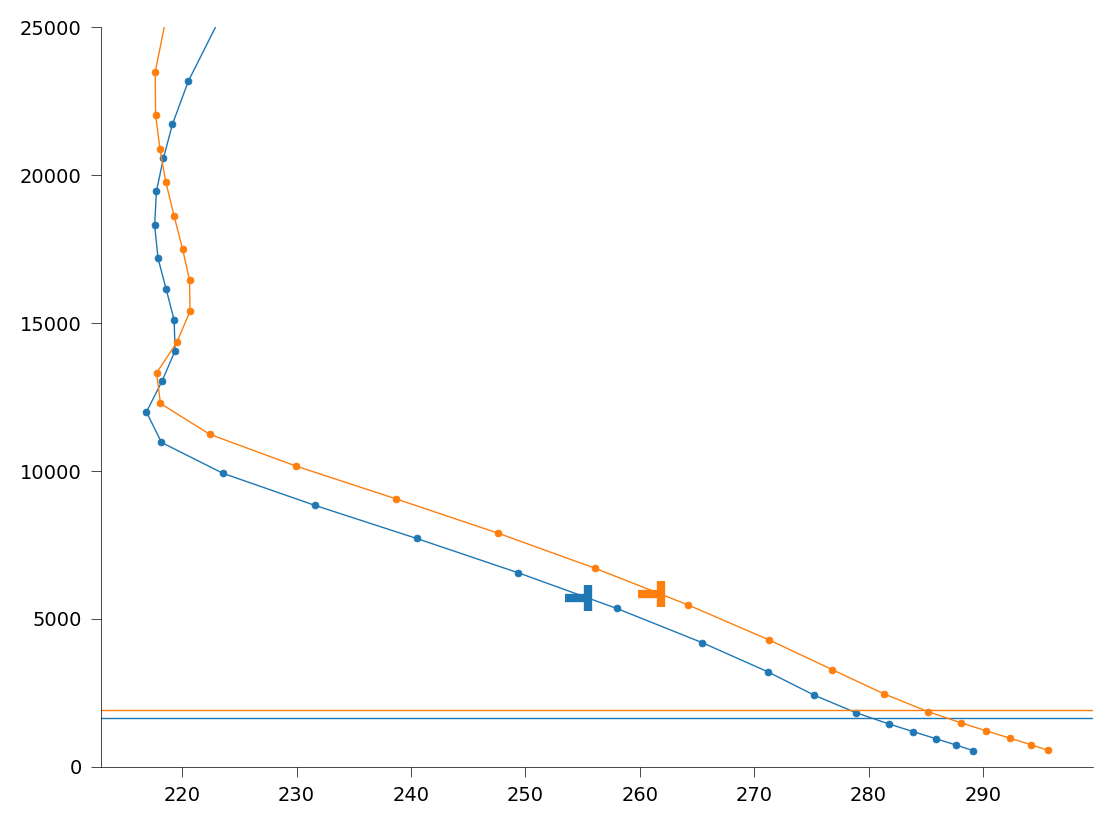

In [540]:
quant_ind_plot = 0
for i in range(2):
    plt.plot(ds_use.T.isel(co2=i, quant=quant_ind_plot), ds_use.Z3.isel(co2=i, quant=quant_ind_plot), marker='.', markersize=5, color=f'C{i}')
    plt.axhline(ds_use.Z3_lcl.isel(quant=quant_ind_plot, co2=i), color=f'C{i}')
    plt.scatter(ds_use.T_zonal_av_ft.isel(quant=quant_ind_plot, co2=i), ds_use.Z3_ft.isel(quant=quant_ind_plot, co2=i), color=f'C{i}',
                marker='_', s=90, lw=3)
    plt.scatter(ds_use.T_ft.isel(quant=quant_ind_plot, co2=i), ds_use.Z3_ft.isel(quant=quant_ind_plot, co2=i), color=f'C{i}',
                marker='|', s=90, lw=3)
plt.ylim(0, 25000)
# ds.sel(lat=-30, lon=140, co2=1, method='nearest')
# plt.axhline(ds.sel(lat=-30, lon=140, co2=2, quant=50, method='nearest').Z3_lcl)
# plt.axhline(ds.sel(lat=-30, lon=140, co2=2, quant=95, method='nearest').Z3_lcl, color='C1')

In [506]:
lapse_moist(275, 1000*100)*1000

6.240594788204206